# Try-it 8.1: The "Best" Model

This module was all about regression and using Python's scikitlearn library to build regression models.  Below, a dataset related to real estate prices in California is given. While many of the assignments you have built and evaluated different models, it is important to spend some time interpreting the resulting "best" model.  


Your goal is to build a regression model to predict the price of a house in California.  After doing so, you are to *interpret* the model.  There are many strategies for doing so, including some built in methods from scikitlearn.  One example is `permutation_importance`.  Permutation feature importance is a strategy for inspecting a model and its features importance.  

Take a look at the user guide for `permutation_importance` [here](https://scikit-learn.org/stable/modules/permutation_importance.html).  Use  the `sklearn.inspection` modules implementation of `permutation_importance` to investigate the importance of different features to your regression models.  Share these results on the discussion board.

# Imports

In [2]:
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
import plotly_express as px
from IPython.display import Image

In [3]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

## Read

In [4]:
df = pd.read_csv("./data/housing.csv")
df.rename(columns={"median_house_value": "median_price"}, inplace=True)
# display(df.head())
# display(df.info())

## Drop Nulls

In [5]:
n_in = len(df)
df.dropna(inplace=True)
n_kept = len(df)
n_dropped = n_in - n_kept
print(
    "Data Frame size in = %d, dropped = %d, retained = %d (%.2f%% dropped, retained %.2f%%)"
    % (n_in, n_dropped, n_kept, n_dropped / n_in * 100.0, n_kept / n_in * 100.0)
)

Data Frame size in = 20640, dropped = 207, retained = 20433 (1.00% dropped, retained 99.00%)


In [6]:
display(df.head())
display(df.info())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_price,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_price        20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


None

## Just for Fun: Scatter of lat x long colored by Ocean Proximity

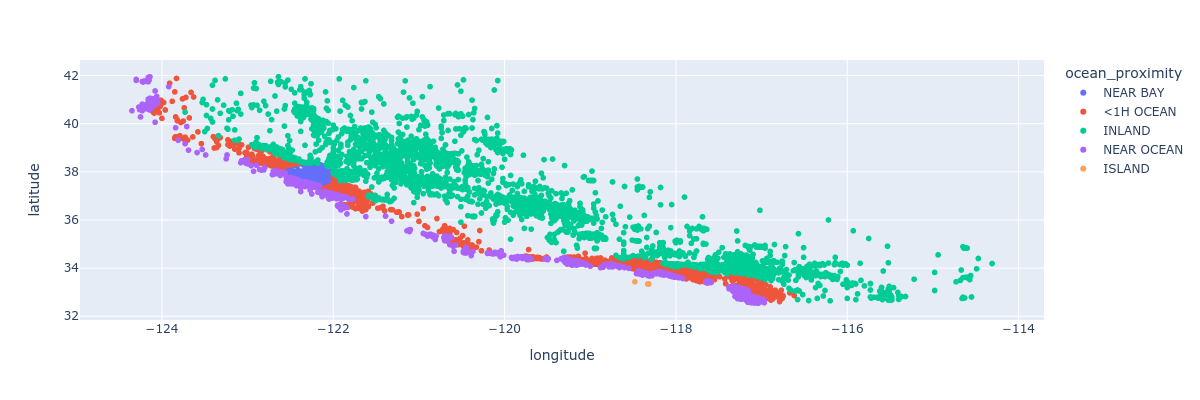

In [7]:
Image(
    px.scatter(df, x="longitude", y="latitude", color="ocean_proximity").to_image(
        format="png", width=1200, height=400, scale=1
    )
)

# Looking at Price by Ocean Proximity

Assume price tracks with ocean distance (i.e. ocean proximity is *ordinal*), but let's check that

In [8]:
df["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: count, dtype: int64

## Note only 5 island data points

Probably better to toss than do anything with

In [9]:
df["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

## Boxen of Price

<Axes: xlabel='ocean_proximity', ylabel='median_price'>

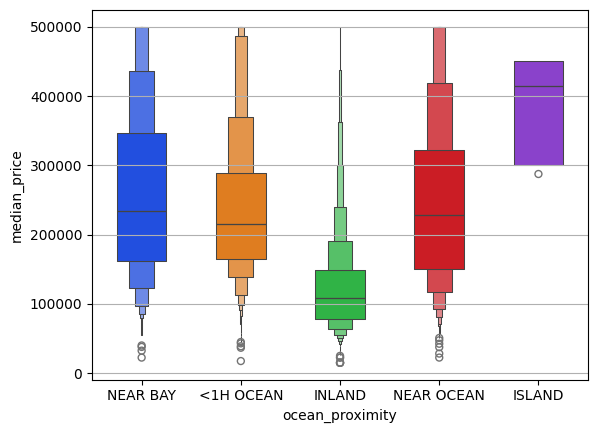

In [10]:
sns.boxenplot(
    data=df,
    x="ocean_proximity",
    y="median_price",
    width=0.5,
    palette="bright",
)

Near bay, near ocean, and within 1 hour of ocean pretty smooshed together, so not ordinal

## KDE Distributions of Price

<Axes: xlabel='median_price', ylabel='Density'>

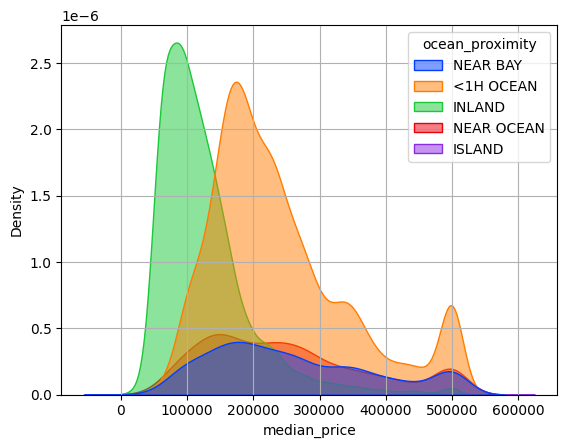

In [11]:
sns.kdeplot(
    df,
    x="median_price",
    fill=True,
    hue="ocean_proximity",
    palette="bright",
    alpha=0.5,
    linewidth=1,
)

## Bar Plot of Price

### Calculate mean and median price grouped by distance from ocean

In [12]:
avg_price_by_ocean = (
    df.groupby("ocean_proximity")
    .agg(
        avg_median_price=("median_price", "mean"),
        med_median_price=("median_price", "median"),
        count=("median_price", "count"),
    )
    .reset_index()
    .apply(round)
    .sort_values(by="med_median_price", ascending=True)
)

display(avg_price_by_ocean)

,ocean_proximity,avg_median_price,med_median_price,count
1,INLAND,124897.0,108700.0,6496
0,<1H OCEAN,240268.0,215000.0,9034
4,NEAR OCEAN,249042.0,228750.0,2628
3,NEAR BAY,259279.0,233800.0,2270
2,ISLAND,380440.0,414700.0,5


### Plot it

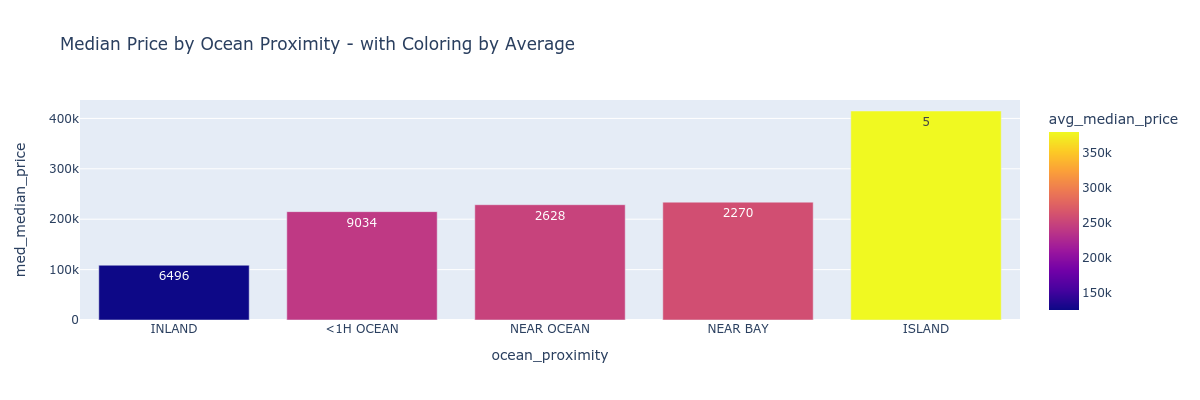

In [13]:
fig = px.bar(
    avg_price_by_ocean,
    x="ocean_proximity",
    y="med_median_price",
    text="count",
    color="avg_median_price",
    title="Median Price by Ocean Proximity - with Coloring by Average",
)

# fig.show()
Image(fig.to_image(format="png", width=1200, height=400, scale=1))

## Conclusion - Ocean Proximity Not Ordinal

### Perform the replacement

And drop island because only 5 points

In [14]:
df_ocean = df.copy(deep=True).query("ocean_proximity != 'ISLAND'")
df_ocean["ocean_proximity"].replace(
    ["NEAR OCEAN", "NEAR BAY"],
    "NEAR OCEAN or BAY",
    inplace=True,
)
df_ocean.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_price,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR OCEAN or BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR OCEAN or BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR OCEAN or BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR OCEAN or BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR OCEAN or BAY


In [15]:
df_ocean["ocean_proximity"].unique()

array(['NEAR OCEAN or BAY', '<1H OCEAN', 'INLAND'], dtype=object)

In [16]:
df_ocean["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN            9034
INLAND               6496
NEAR OCEAN or BAY    4898
Name: count, dtype: int64

### Plots After Grouping

#### Boxen

<Axes: xlabel='ocean_proximity', ylabel='median_price'>

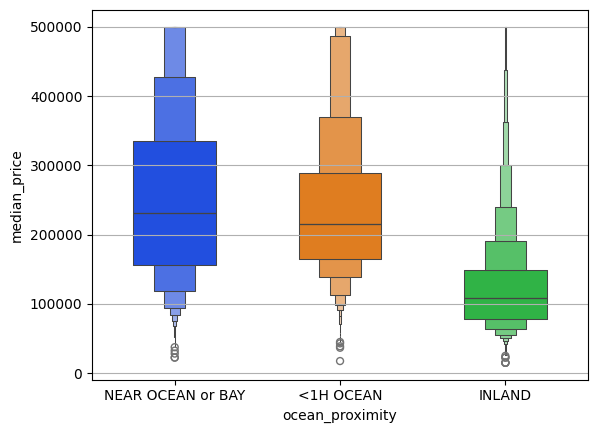

In [17]:
sns.boxenplot(
    data=df_ocean,
    x="ocean_proximity",
    y="median_price",
    width=0.5,
    palette="bright",
)

#### KDE

<Axes: xlabel='median_price', ylabel='Density'>

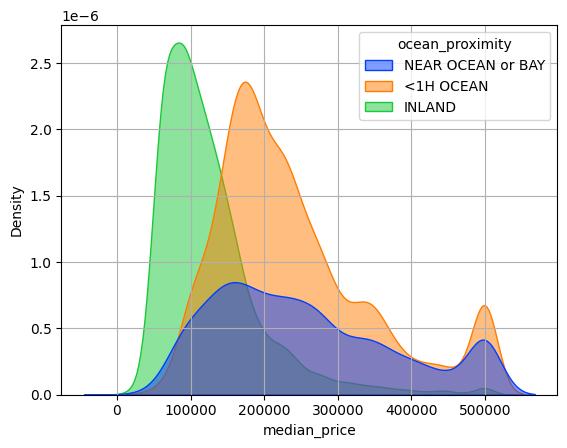

In [18]:
sns.kdeplot(
    df_ocean,
    x="median_price",
    fill=True,
    hue="ocean_proximity",
    palette="bright",
    alpha=0.5,
    linewidth=1,
)

# Regression Modeling

## Make a Split

In [19]:
df_no_target = df_ocean.drop(columns="median_price")
target = df_ocean["median_price"]
(X_train, X_dev, y_train, y_dev) = train_test_split(
    df_no_target,
    target,
    random_state=123,
    test_size=0.25,
)

display([X_train.shape, X_dev.shape])

[(15321, 9), (5107, 9)]

In [20]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
20559,-121.79,38.67,30.0,2602.0,401.0,981.0,405.0,4.7222,INLAND
14851,-117.08,32.67,31.0,3008.0,764.0,2088.0,757.0,2.5662,NEAR OCEAN or BAY
9029,-118.78,34.05,28.0,1343.0,215.0,487.0,199.0,6.8300,NEAR OCEAN or BAY
9966,-122.40,38.46,33.0,2542.0,466.0,1099.0,420.0,4.6350,INLAND
5233,-118.24,33.94,39.0,1215.0,273.0,1211.0,265.0,1.7212,<1H OCEAN


## Form a Baseline

### What Correlates with Price?

In [21]:
df_ocean.corr(numeric_only=True)["median_price"].sort_values(ascending=True)

latitude             -0.144312
longitude            -0.045642
population           -0.025069
total_bedrooms        0.049792
households            0.065122
housing_median_age    0.106077
total_rooms           0.133516
median_income         0.688848
median_price          1.000000
Name: median_price, dtype: float64

#### Income Correlates with Price

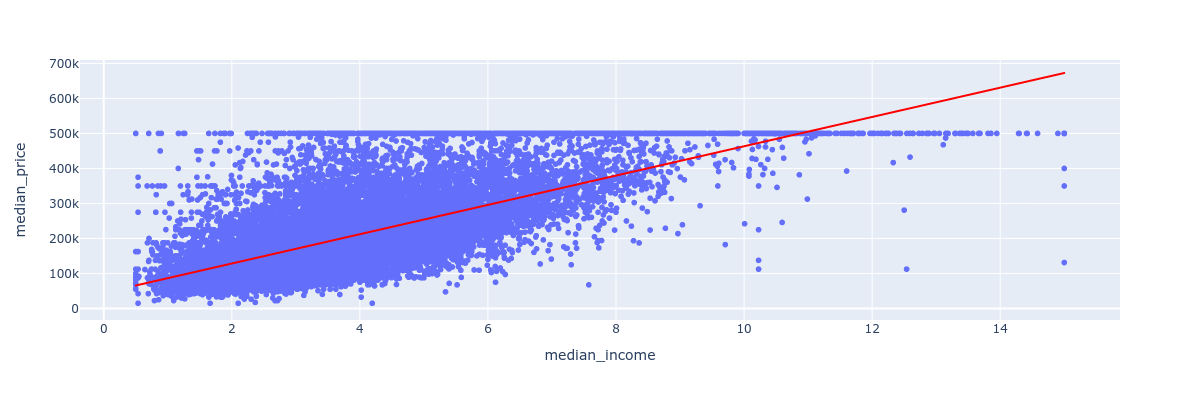

In [22]:
Image(
    px.scatter(
        df_ocean,
        x="median_income",
        y="median_price",
        # color="ocean_proximity",
        trendline="ols",
        trendline_color_override="red",
    ).to_image(format="png", width=1200, height=400, scale=1)
)

#### Apparently average price is hard capped at 500k?

In [23]:
df_ocean.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_price
count,20428.000000,20428.000000,20428.000000,20428.000000,20428.000000,20428.000000,20428.000000,20428.000000,20428.000000
mean,-119.570986,35.633778,28.629724,2636.764147,537.899305,1425.132220,499.488007,3.871437,206821.928432
std,2.003732,2.136312,12.590156,2185.451409,421.425970,1133.277418,382.326831,1.899432,115412.337452
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,788.000000,280.000000,2.563400,119475.000000
50%,-118.500000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.537500,179700.000000
75%,-118.010000,37.720000,37.000000,3143.250000,647.000000,1723.000000,604.000000,4.744075,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Baseline - Linear Function of Income

In [24]:
model_baseline = LinearRegression(fit_intercept=True).fit(
    X_train[["median_income"]], y_train
)

baseline_mse = mean_squared_error(
    y_train, model_baseline.predict(X_train[["median_income"]])
)

baseline_mse / 1e6

6958.008686288625

## Make a Fully-Featured Model

In [84]:
features = [
    "longitude",
    "latitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    # "households",
    "median_income",
    # "ocean_proximity",
]

train_mses = []
dev_mses = []

for degree in range(1, 3):
    # Make column transformer: one-hot for the ocean proximity and poly features for everything else
    xformer = make_column_transformer(
        # (OneHotEncoder(), ["ocean_proximity"]),
        (
            PolynomialFeatures(degree=degree),
            make_column_selector(dtype_include=np.number),
        ),
    )

    # Build the pipeline and fit
    pipe = Pipeline([("transform", xformer), ("regression", LinearRegression())]).fit(
        X_train[features], y_train
    )

    # Compute mean squared errors
    train_mses.append(mean_squared_error(y_train, pipe.predict(X_train[features])))
    dev_mses.append(mean_squared_error(y_dev, pipe.predict(X_dev[features])))

display(np.array(train_mses) / 1e6)
display(np.array(dev_mses) / 1e6)

array([4804.99842533, 3995.08723585])

array([4960.03173835, 4143.11688137])